<a href="https://colab.research.google.com/github/SLCFLAB/hd2025_time_series/blob/main/day3/Day3_1_Data%20Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 시계열 데이터 전처리

딥러닝 모델을 위한 시계열 데이터 전처리 실습 가이드

본 실습에선 시계열 데이터를 다루는 모델을 학습시키기 전에 필요한 **데이터 전처리** 과정을 상세한 설명과 함께 다룹니다.

모델이 데이터를 잘 이해하고 패턴을 효과적으로 학습하려면, 잘 정제된 데이터를 입력해야 합니다. 지금부터 그 과정을 하나씩 실습해 보겠습니다.

### 1. 라이브러리 및 데이터 로드

먼저, 실습에 필요한 라이브러리들을 불러오고 예제로 사용할 **항공 승객 수 데이터**를 로드합니다. 이 데이터는 전처리 과정을 설명하기에 아주 적합한 간단한 시계열 데이터입니다.

--- 원본 데이터 (처음 5개) ---
            Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121


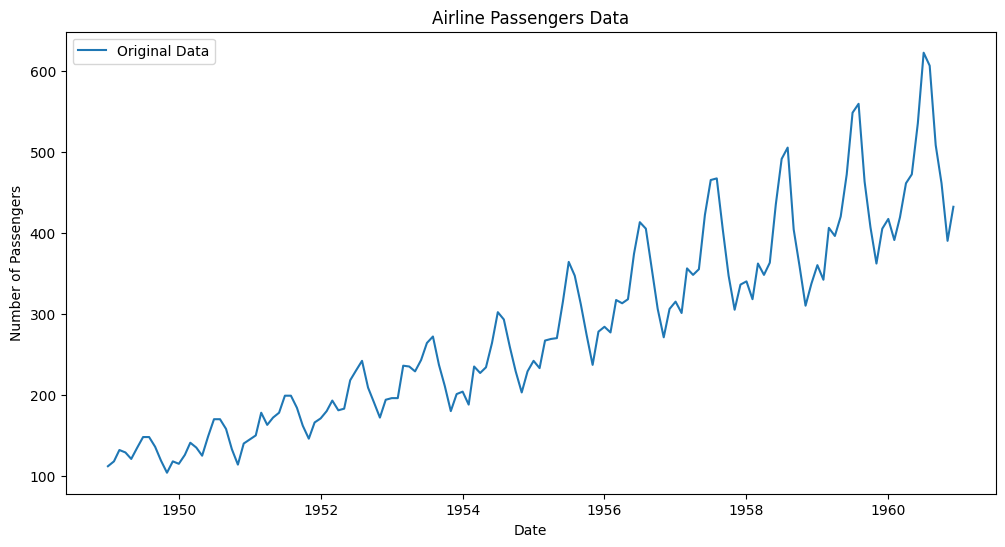

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# 데이터셋 로드
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
df = pd.read_csv(url)
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

print("--- 원본 데이터 (처음 5개) ---")
print(df.head())

# 원본 데이터 시각화
plt.figure(figsize=(12, 6))
plt.plot(df['Passengers'], label='Original Data')
plt.title('Airline Passengers Data')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

---

### 2. 데이터 정제 (Data Cleaning) - 결측치 처리

가장 먼저 데이터에 비어있는 값, 즉 **결측치(Missing Values)** 가 있는지 확인합니다. 실습을 위해 일부러 중간에 **결측치(NaN)** 를 추가해 보겠습니다.

아래 코드를 실행하여 데이터셋의 각 열에 몇 개의 결측치가 있는지 확인할 수 있습니다.

In [2]:
# 실습을 위해 인위적으로 결측치(NaN) 생성
df.iloc[5:8, 0] = np.nan

print("--- 결측치가 추가된 원본 데이터 ---")
print(df.head(10))

print("--- 열(Column)별 결측치 개수 ---")
print(df.isnull().sum())

--- 결측치가 추가된 원본 데이터 ---
            Passengers
Month                 
1949-01-01       112.0
1949-02-01       118.0
1949-03-01       132.0
1949-04-01       129.0
1949-05-01       121.0
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01       136.0
1949-10-01       119.0
--- 열(Column)별 결측치 개수 ---
Passengers    3
dtype: int64


시계열 데이터를 예측하는 것은 **'과거의 데이터'를 기반으로 '미래'를 맞추는 것**입니다. 따라서 결측치를 처리할 때도 이 원칙을 반드시 지켜야 합니다.

**왜 `ffill` (Forward Fill)을 사용해야 하는가?**

- 만약 데이터의 평균이나 중앙값으로 결측치를 채운다면, **미래 시점의 정보까지 포함된 통계치**를 사용하게 됩니다. 이는 마치 미래의 답안지를 보고 과거의 문제를 푸는 것과 같아 모델의 성능을 왜곡시킵니다. (이러한 현상을 **Data Leakage** 라고 합니다.)
- `ffill`은 결측치가 나타난 시점에서 **가장 최근의 과거 값**으로 채우는 방식입니다. 이는 현실에서 데이터를 예측하는 방식과 일치하므로 시계열 데이터에 매우 적합합니다.

In [3]:
# 이전 시점의 값으로 결측치를 채움 (Forward Fill)
df['Passengers'] = df['Passengers'].ffill()

print("\n--- 처리 후 결측치 확인 ---")
print(df.isnull().sum())

print("\n--- 결측치 처리 결과 확인 ---")
print(df.head(10))


--- 처리 후 결측치 확인 ---
Passengers    0
dtype: int64

--- 결측치 처리 결과 확인 ---
            Passengers
Month                 
1949-01-01       112.0
1949-02-01       118.0
1949-03-01       132.0
1949-04-01       129.0
1949-05-01       121.0
1949-06-01       121.0
1949-07-01       121.0
1949-08-01       121.0
1949-09-01       136.0
1949-10-01       119.0



--- 결측치 처리 결과 확인 (Plot) ---


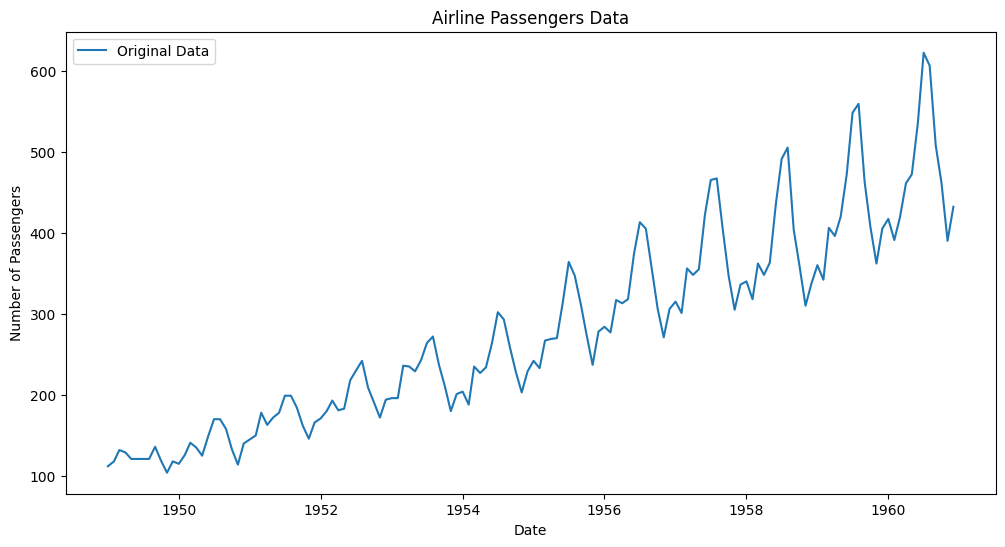

In [4]:
print("\n--- 결측치 처리 결과 확인 (Plot) ---")

plt.figure(figsize=(12, 6))
plt.plot(df['Passengers'], label='Original Data')
plt.title('Airline Passengers Data')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

---

### 3. 데이터 분할 (Train/Test Split)

**데이터 스케일링을 하기 전에 반드시 훈련/테스트 데이터부터 분할해야 합니다.** 만약 전체 데이터를 스케일링한 후 분할한다면, 훈련 데이터를 스케일링할 때 테스트 데이터의 최솟값, 최댓값, 평균 등의 정보가 섞여 들어가게 됩니다. 이 또한 심각한 **Data Leakage** 문제입니다.

시계열 데이터는 시간 순서가 중요하므로, **절대 섞지 않고(shuffle=False)** 시간 순서에 따라 분할합니다.

In [5]:
passengers_data = df['Passengers'].values.astype('float32').reshape(-1, 1)

# 시간 순서에 따라 70%를 훈련, 30%를 테스트 데이터로 분할
train_size = int(len(passengers_data) * 0.7)
train_data = passengers_data[0:train_size]
test_data = passengers_data[train_size:len(passengers_data)]

print("--- 데이터 분할 결과 ---")
print(f"전체 데이터 크기: {len(passengers_data)}")
print(f"훈련 데이터 크기: {len(train_data)}")
print(f"테스트 데이터 크기: {len(test_data)}")

--- 데이터 분할 결과 ---
전체 데이터 크기: 144
훈련 데이터 크기: 100
테스트 데이터 크기: 44


---

### 4. 데이터 스케일링 (Feature Scaling)

이제 분할된 데이터를 스케일링합니다. 여기서 가장 중요한 규칙이 있습니다.

> **규칙: Scaler는 `훈련 데이터(Train Data)`에만 `fit` 해야 합니다.**

모델은 훈련 과정에서 테스트 데이터를 본 적이 없는 상태여야 합니다. 따라서 **테스트 데이터의 통계 정보(평균, 분산, 최소/최대)가 스케일링 과정에 반영되어서는 안됩니다.**
- `fit_transform()`: 훈련 데이터의 통계 정보를 **학습(`fit`)**하고, 그 기준으로 데이터를 **변환(`transform`)** 합니다.
- `transform()`: 이미 학습된 훈련 데이터의 통계 정보를 그대로 사용하여, 새로운 데이터(테스트 데이터)를 **변환**만 합니다.

#### 방법 1: 표준화 (Standardization)
데이터를 평균 0, 표준편차 1을 갖도록 변환합니다. `StandardScaler`를 사용합니다.

In [6]:
# 1. StandardScaler 객체 생성
scaler_std = StandardScaler()

# 2. 훈련 데이터에 fit_transform 적용
train_data_scaled_std = scaler_std.fit_transform(train_data)

# 3. 테스트 데이터에는 transform만 적용
test_data_scaled_std = scaler_std.transform(test_data)

print("--- 표준화 스케일링 결과 ---")
print(f"훈련 데이터 평균: {train_data_scaled_std.mean():.2f}, 분산: {train_data_scaled_std.var():.2f}")
print(f"테스트 데이터 평균: {test_data_scaled_std.mean():.2f}, 분산: {test_data_scaled_std.var():.2f}")

--- 표준화 스케일링 결과 ---
훈련 데이터 평균: -0.00, 분산: 1.00
테스트 데이터 평균: 2.73, 분산: 1.05


--- 원본 데이터 ---


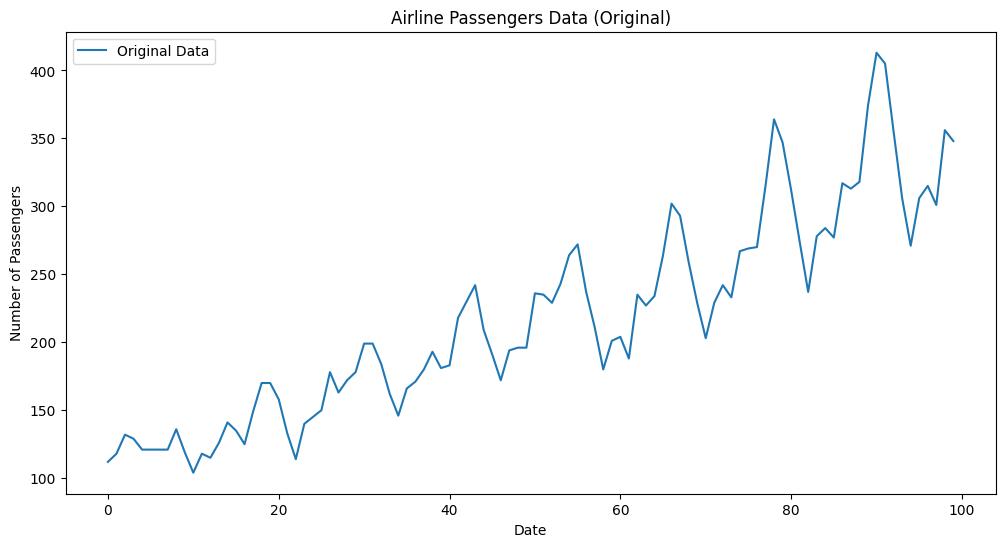


--- 스케일링된 데이터 ---


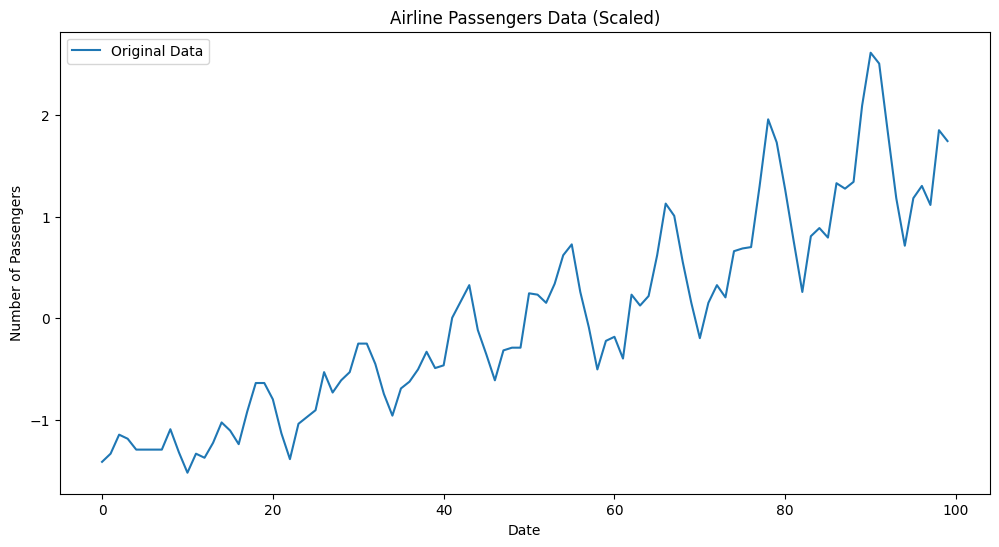

In [7]:
print("--- 원본 데이터 ---")
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Original Data')
plt.title('Airline Passengers Data (Original)')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

print("\n--- 스케일링된 데이터 ---")
plt.figure(figsize=(12, 6))
plt.plot(train_data_scaled_std, label='Original Data')
plt.title('Airline Passengers Data (Scaled)')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

#### 방법 2: 정규화 (Normalization)
데이터를 0과 1 사이의 값으로 변환합니다. `MinMaxScaler`를 사용합니다.

In [8]:
# 1. MinMaxScaler 객체 생성
scaler_minmax = MinMaxScaler(feature_range=(0, 1))

# 2. 훈련 데이터에 fit_transform 적용
train_data_scaled_mm = scaler_minmax.fit_transform(train_data)

# 3. 테스트 데이터에는 transform만 적용
test_data_scaled_mm = scaler_minmax.transform(test_data)

print("--- 정규화 스케일링 결과 ---")
print(f"훈련 데이터 최소값: {train_data_scaled_mm.min():.2f}, 최대값: {train_data_scaled_mm.max():.2f}")
print(f"테스트 데이터 최소값: {test_data_scaled_mm.min():.2f}, 최대값: {test_data_scaled_mm.max():.2f}")

# 이후 실습에서는 정규화된 데이터를 사용합니다.
scaled_train_data = train_data_scaled_mm
scaled_test_data = test_data_scaled_mm

--- 정규화 스케일링 결과 ---
훈련 데이터 최소값: 0.00, 최대값: 1.00
테스트 데이터 최소값: 0.65, 최대값: 1.68


--- 원본 데이터 ---


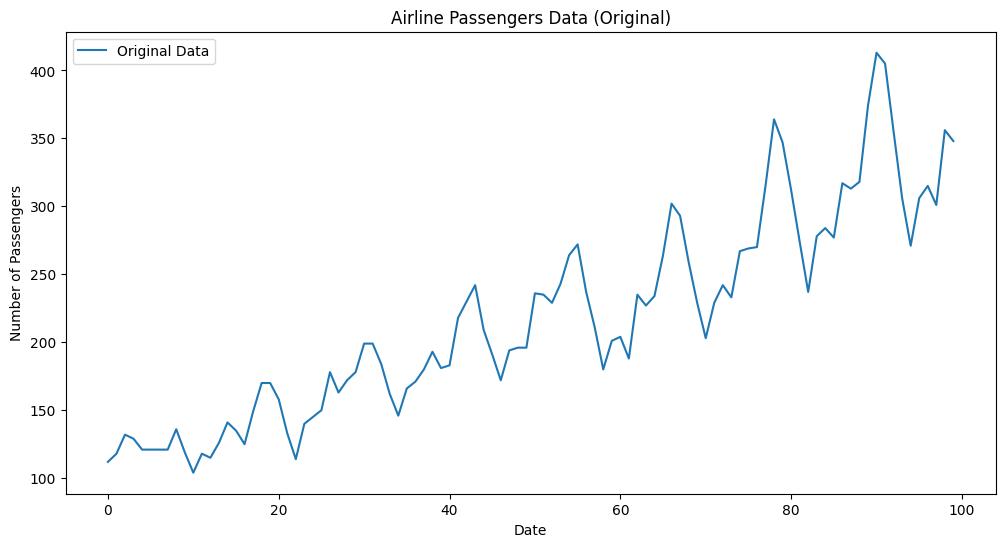


--- 스케일링된 데이터 ---


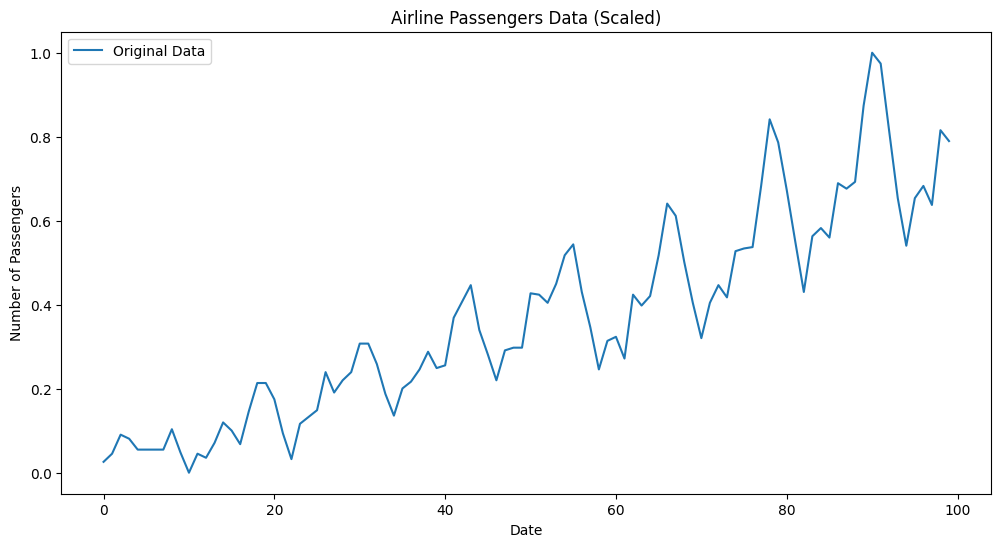

In [9]:
print("--- 원본 데이터 ---")
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Original Data')
plt.title('Airline Passengers Data (Original)')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

print("\n--- 스케일링된 데이터 ---")
plt.figure(figsize=(12, 6))
plt.plot(train_data_scaled_mm, label='Original Data')
plt.title('Airline Passengers Data (Scaled)')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

---

### 5. 지도학습 데이터셋 변환 (Supervised Learning Dataset)

시계열 데이터를 딥러닝 모델이 학습할 수 있는 **지도학습** 데이터 형태, 즉 `입력(X)`과 `정답(y)`의 쌍으로 변환합니다. **슬라이딩 윈도우(Sliding Window)** 기법을 사용하여 이 작업을 수행합니다.

예를 들어 `look_back = 3` 이라면, 과거 3개월의 데이터를 보고 다음 달을 예측하는 데이터셋을 만듭니다.

In [10]:
def create_dataset(data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(data) - look_back):
        dataX.append(data[i:(i + look_back), 0])
        dataY.append(data[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 12
trainX, trainY = create_dataset(scaled_train_data, look_back)
testX, testY = create_dataset(scaled_test_data, look_back)

print("--- 지도학습 데이터셋 변환 결과 ---")
print(f"trainX shape: {trainX.shape}, trainY shape: {trainY.shape}")
print(f"testX shape: {testX.shape}, testY shape: {testY.shape}")

--- 지도학습 데이터셋 변환 결과 ---
trainX shape: (88, 12), trainY shape: (88,)
testX shape: (32, 12), testY shape: (32,)


---

### 6. 딥러닝 모델을 위한 형태 변환 (Reshaping)

마지막으로, RNN이나 LSTM 같은 딥러닝 모델이 요구하는 3차원 입력 형태 `(샘플 수, 타임스텝, 피처 수)`로 데이터를 변환합니다.

- **샘플 수:** 데이터의 개수
- **타임스텝:** `look_back` 값
- **피처 수:** 변수의 개수 (이 예제에서는 승객 수 하나이므로 1)

In [11]:
# (샘플, 타임스텝, 피처) 형태로 Reshape
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

print("--- 최종 데이터 형태 ---")
print(f"훈련 데이터 X 형태: {trainX.shape}")
print(f"테스트 데이터 X 형태: {testX.shape}")

--- 최종 데이터 형태 ---
훈련 데이터 X 형태: (88, 12, 1)
테스트 데이터 X 형태: (32, 12, 1)


---

### 7. 간단한 딥러닝 모델 학습해보기

**RNN(Recurrent Neural Network)** 은 순환 구조를 통해 순서가 있는 데이터를 처리하는 데 적합한 모델입니다. PyTorch를 사용하여 RNN 모델을 정의하고 학습을 진행합니다.

In [12]:
import torch.nn as nn
import torch

# RNN 모델 정의
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # 초기 hidden state 설정
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        # RNN 순전파
        out, _ = self.rnn(x, h0)
        # 마지막 time step의 출력만 사용
        out = self.fc(out[:, -1, :])
        return out.squeeze(-1)

In [13]:
# PyTorch 텐서로 변환
trainX = torch.from_numpy(trainX).float()
trainY = torch.from_numpy(trainY).float()
testX = torch.from_numpy(testX).float()
testY = torch.from_numpy(testY).float()

# 모델, 손실 함수, 옵티마이저 설정
input_size = 1
hidden_size = 128
output_size = 1
learning_rate = 0.001
num_epochs = 1000

In [14]:
rnn_model = RNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=learning_rate)

# 모델 학습
rnn_loss_history = []
print("--- RNN 모델 학습 시작 ---")
for epoch in range(num_epochs):
    rnn_model.train()
    outputs = rnn_model(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()
    rnn_loss_history.append(loss.item())
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')
print("--- RNN 모델 학습 완료 ---")

--- RNN 모델 학습 시작 ---
Epoch [100/1000], Loss: 0.006624
Epoch [200/1000], Loss: 0.003138
Epoch [300/1000], Loss: 0.002530
Epoch [400/1000], Loss: 0.002404
Epoch [500/1000], Loss: 0.005542
Epoch [600/1000], Loss: 0.002106
Epoch [700/1000], Loss: 0.001724
Epoch [800/1000], Loss: 0.002126
Epoch [900/1000], Loss: 0.001517
Epoch [1000/1000], Loss: 0.001405
--- RNN 모델 학습 완료 ---


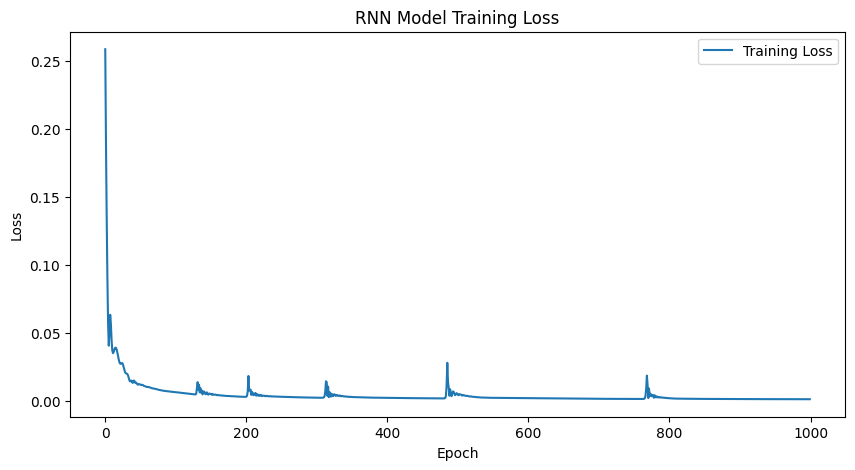

In [15]:
# 1. 학습 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(rnn_loss_history, label='Training Loss')
plt.title('RNN Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
# 2. 예측 결과 시각화
rnn_model.eval()
with torch.no_grad():
    rnn_train_predict = rnn_model(trainX).numpy()
    rnn_test_predict = rnn_model(testX).numpy()

# 원래 스케일로 변환
rnn_train_predict = scaler_minmax.inverse_transform(rnn_train_predict.reshape(-1, 1))
rnn_test_predict = scaler_minmax.inverse_transform(rnn_test_predict.reshape(-1, 1))

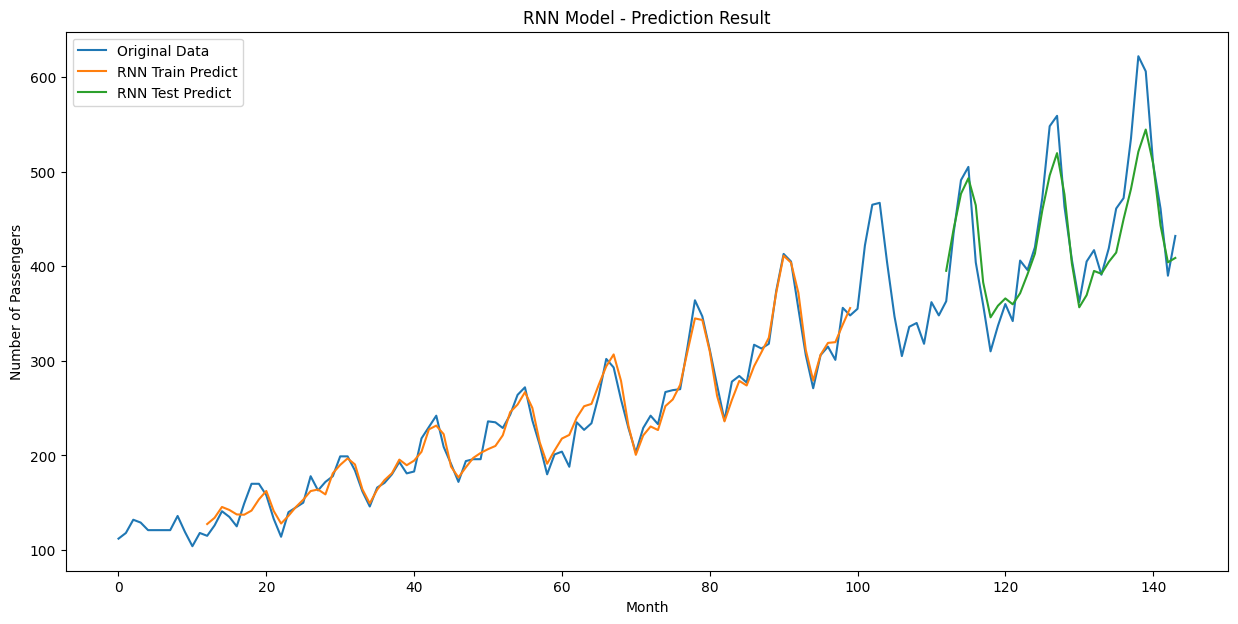

In [17]:
# 시각화를 위한 배열 생성
rnn_train_plot = np.empty_like(passengers_data)
rnn_train_plot[:, :] = np.nan
rnn_train_plot[look_back:len(rnn_train_predict)+look_back, :] = rnn_train_predict

rnn_test_plot = np.empty_like(passengers_data)
rnn_test_plot[:, :] = np.nan
rnn_test_plot[len(rnn_train_predict)+(look_back*2):len(passengers_data), :] = rnn_test_predict

# 결과 플롯
plt.figure(figsize=(15, 7))
plt.plot(passengers_data, label='Original Data')
plt.plot(rnn_train_plot, label='RNN Train Predict')
plt.plot(rnn_test_plot, label='RNN Test Predict')
plt.title('RNN Model - Prediction Result')
plt.xlabel('Month')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

---

### 8. 심화: 비정상성 데이터를 위한 동적 스케일링 (Instance Scaling)

#### 기존 방식의 한계점
항공 승객 데이터처럼 **지속적으로 증가하는 추세**를 가진 데이터를 '비정상성(Non-stationary) 데이터'라고 합니다. 이러한 데이터의 경우, 훈련 데이터의 통계적 특성(평균, 분산, 최소/최대)과 테스트 데이터의 특성이 매우 다릅니다.

만약 **훈련 데이터의 통계치로 테스트 데이터를 스케일링하면**, 모델은 **생전 처음 보는 범위의 값**들을 만나게 되어 예측 성능이 크게 저하될 수 있습니다.

#### 해결책: 동적 스케일링
이 문제를 해결하기 위해, 데이터 전체를 한 번에 스케일링하는 대신, 모델에 입력되는 **각각의 윈도우(데이터 조각) 단위로** 스케일링을 수행합니다. 이를 '인스턴스 스케일링'이라고도 합니다.

**프로세스:**
1. 모델에 **하나의 입력 윈도우 `X`** 가 들어옵니다.
2. **`X` 자체의 평균과 표준편차**를 계산합니다.
3. 이 통계치를 사용하여 `X`와 정답 `Y`를 스케일링합니다.
4. 스케일링된 `X`를 모델에 입력하여 예측값(스케일링된 값)을 얻습니다.
5. 예측값을 다시 원래 값으로 되돌릴 때, **2번에서 계산했던 바로 그 `X`의 평균과 표준편차**를 사용하여 역변환합니다.

이렇게 하면 모델은 값의 절대적인 크기가 아닌, **해당 윈도우 내에서의 상대적인 패턴**에 집중하여 학습할 수 있게 되어 훨씬 강건한 예측이 가능해집니다.

In [18]:
class ScaledRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ScaledRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.epsilon = 1e-8 # 0으로 나누는 것을 방지하기 위한 작은 값

    def forward(self, x):
        # x의 현재 shape: (배치 크기, 시퀀스 길이)

        # 1. 각 인스턴스(윈도우)의 평균과 표준편차 계산
        # keepdim=True로 차원을 유지하여 브로드캐스팅이 가능하게 함
        mean = x.mean(dim=1, keepdim=True)
        std = x.std(dim=1, keepdim=True) + self.epsilon
        x_scaled = (x - mean)/std
        # 3. RNN과 FC 레이어 통과 (출력은 스케일링된 상태)
        out_scaled, _ = self.rnn(x_scaled)
        out_scaled = self.fc(out_scaled[:, -1, :]) # 마지막 타임스텝의 출력만 사용
        # 4. 출력값을 다시 원래 스케일로 복원 (Unscaling)
        out_unscaled = (out_scaled.unsqueeze(1) * std) + mean
        return out_unscaled[:, 0, 0] # 최종 shape: (배치 크기)

--- 모델 학습 시작 ---
Epoch [100/1000], Loss: 0.00
Epoch [200/1000], Loss: 0.00
Epoch [300/1000], Loss: 0.00
Epoch [400/1000], Loss: 0.00
Epoch [500/1000], Loss: 0.00
Epoch [600/1000], Loss: 0.00
Epoch [700/1000], Loss: 0.00
Epoch [800/1000], Loss: 0.00
Epoch [900/1000], Loss: 0.00
Epoch [1000/1000], Loss: 0.00
--- 모델 학습 완료 ---


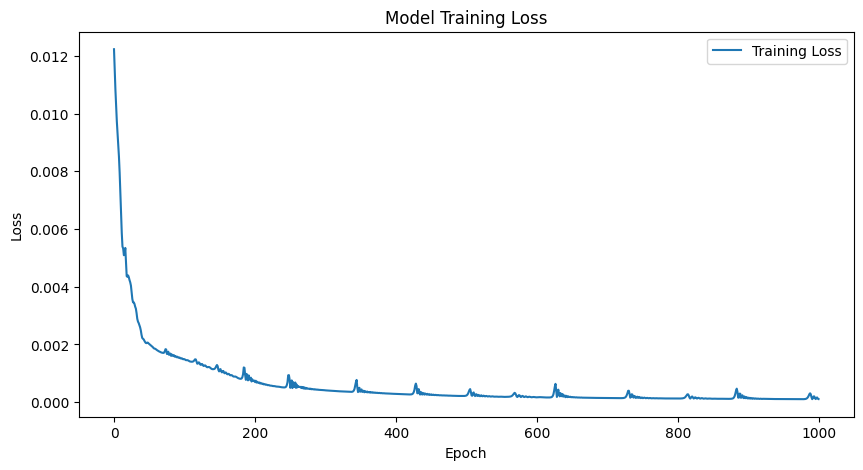

In [19]:
# 모델, 손실 함수, 옵티마이저 설정
input_size = 1
hidden_size = 128
output_size = 1
learning_rate = 0.001
num_epochs = 1000

model = ScaledRNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss() # 손실 함수: 평균 제곱 오차
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 모델 학습
loss_history = []
print("--- 모델 학습 시작 ---")
for epoch in range(num_epochs):
    model.train()

    # 모델은 원본 데이터를 받아 내부에서 스케일링을 처리함
    outputs = model(trainX)

    # 모델이 원본 스케일의 예측값을 반환하므로, 원본 정답(trainY)과 바로 비교
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.2f}')
print("--- 모델 학습 완료 ---")

# 학습 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Training Loss')
plt.title('Model Training Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
plt.show()

In [20]:
# 2. 예측 결과 시각화
model.eval()
with torch.no_grad():
    scaled_rnn_train_predict = model(trainX).numpy()
    scaled_rnn_test_predict = model(testX).numpy()

# 원래 스케일로 변환
scaled_rnn_train_predict = scaler_minmax.inverse_transform(scaled_rnn_train_predict.reshape(-1, 1))
scaled_rnn_test_predict = scaler_minmax.inverse_transform(scaled_rnn_test_predict.reshape(-1, 1))

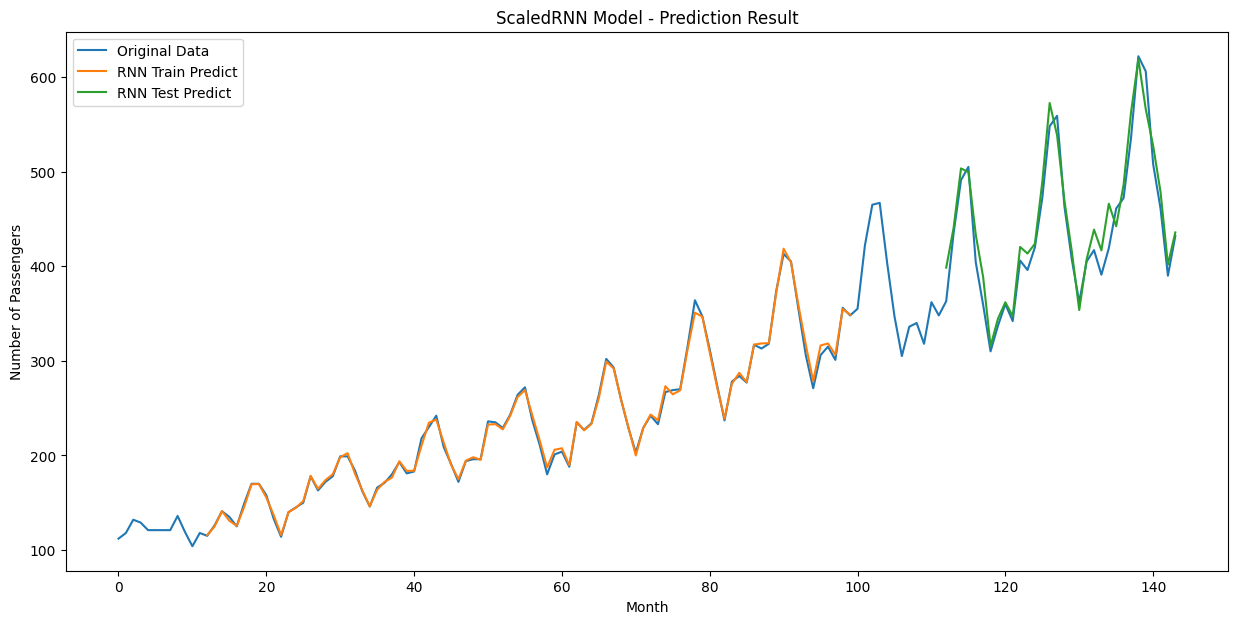

In [21]:
# 시각화를 위한 배열 생성
scaled_rnn_train_plot = np.empty_like(passengers_data)
scaled_rnn_train_plot[:, :] = np.nan
scaled_rnn_train_plot[look_back:len(scaled_rnn_train_predict)+look_back, :] = scaled_rnn_train_predict

scaled_rnn_test_plot = np.empty_like(passengers_data)
scaled_rnn_test_plot[:, :] = np.nan
scaled_rnn_test_plot[len(scaled_rnn_train_predict)+(look_back*2):len(passengers_data), :] = scaled_rnn_test_predict

# 결과 플롯
plt.figure(figsize=(15, 7))
plt.plot(passengers_data, label='Original Data')
plt.plot(scaled_rnn_train_plot, label='RNN Train Predict')
plt.plot(scaled_rnn_test_plot, label='RNN Test Predict')
plt.title('ScaledRNN Model - Prediction Result')
plt.xlabel('Month')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()